## Import Libraries

In [94]:
import os
import cv2
import time
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, \
    AdaptiveAvgPool2d, Sequential, Module
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v2

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [95]:
# Function to extract face with OpenCV
def extract_face(image_path, show=False):
    image = Image.open(image_path)
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    bbox_file = image_path[:-4] + '_BB.txt'
    if os.path.exists(bbox_file):
        bbox = open(bbox_file).readlines()[0]
        bbox = [int(_) for _ in bbox.strip().split()[:4]]
        real_w, real_h = image.size
        x1 = int(bbox[0] * (real_w / 224))
        y1 = int(bbox[1] * (real_h / 224))
        w1 = int(bbox[2] * (real_w / 224))
        h1 = int(bbox[3] * (real_h / 224))
    else:
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        if len(faces) == 0:
            raise ValueError("No face detected in the image.")
        x1, y1, w1, h1 = faces[0]

    face = image.crop((x1, y1, x1 + w1, y1 + h1))
    if show:
        plt.imshow(face)
        plt.show()
    return face

In [ ]:
face = extract_face('/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10001/live/496120.png', show=True)
# face = transforms['train'](face)
type(face)

## Prepare the Dataset

In [97]:
# prepare data
class FASDataset(Dataset):
    def __init__(self, df, transforms=None, ft_width=28, ft_height=28):
        self.df = df
        self.transforms = transforms
        self.ft_width = ft_width
        self.ft_height = ft_height
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Filepath']
        bbox_path = img_path[:-4] + '_BB.txt'
        
        sample = extract_face(img_path)
        target = df_train.iloc[idx][43]
                
        # Generate the FT picture of the sample
        ft_sample = self.generate_FT(sample)
        
        if self.transforms is not None:
            try:
                sample = self.transforms(sample)
            except Exception as err:
                print('Error Occured: %s' % err, img_path)
        
        assert sample is not None

        ft_sample = cv2.resize(ft_sample, (self.ft_width, self.ft_height))
        ft_sample = torch.from_numpy(ft_sample).float()
        ft_sample = torch.unsqueeze(ft_sample, 0)

        return sample, ft_sample, target
    
    def generate_FT(self, image):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(image)
        fshift = np.fft.fftshift(f)
        fimg = np.log(np.abs(fshift)+1)
        maxx = -1
        minn = 100000
        for i in range(len(fimg)):
            if maxx < max(fimg[i]):
                maxx = max(fimg[i])
            if minn > min(fimg[i]):
                minn = min(fimg[i])
        fimg = (fimg - minn+1) / (maxx - minn+1)
        return fimg

In [98]:
data_dir = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/'
train_size = len(os.listdir(os.path.join(data_dir, 'train')))
test_size = len(os.listdir(os.path.join(data_dir, 'test')))

print('train: {}; test: {}'.format(train_size, test_size))

train: 8192; test: 1004


In [99]:
path_train_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/train_label.json'
path_test_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/test_label.json'
path_local = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/'

In [100]:
df_train = pd.read_json(path_train_json, orient='index')
df_test = pd.read_json(path_test_json, orient='index')

df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train.rename(columns={'index': 'Filepath'}, inplace=True)
df_test.rename(columns={'index': 'Filepath'}, inplace=True)

In [101]:
df_train['Filepath'] = df_train['Filepath'].apply(lambda x: path_local +  x)
df_test['Filepath'] = df_test['Filepath'].apply(lambda x: path_local  + x)

In [102]:
df_train

,Filepath,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
0,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,1,1
2,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,1,1
3,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,2,1
4,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494400,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,1
494401,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,2,1
494402,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
494403,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,2,1


In [103]:
invalid_file_name = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/3329/spoof/004046.jpg'

df_train.drop(df_train[df_train['Filepath']==invalid_file_name].index, inplace=True)
df_train

,Filepath,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
0,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,1,1
2,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,1,1
3,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,1,2,1
4,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494400,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,1
494401,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,2,1
494402,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
494403,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,2,1


In [104]:
df_train.Filepath[0]

'/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/2623/live/000000.jpg'

In [105]:
# load bounding box
bbox = np.loadtxt(df_train.Filepath[15][:-4] + '_BB.txt')
bbox

array([ 63.       ,  54.       ,  92.       , 112.       ,   0.9990876])

In [ ]:
face = extract_face(df_train.Filepath[0], show=True)

In [107]:
# transformations
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [108]:
df_train[43].value_counts()

43
1    331942
0    162462
Name: count, dtype: int64

In [109]:
# down sample the size of trainning set
df_train_sample = df_train.sample(frac=0.02, random_state=4)
df_train_sample[43].value_counts()

43
1    6639
0    3249
Name: count, dtype: int64

In [110]:
df_train_sample

,Filepath,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
114811,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,1,1
458829,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1,1,1
69730,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,2,1
82317,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,1,2,1
104482,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286548,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
218995,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,1,2,1
303918,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
421618,/kaggle/input/celeba-spoof-for-face-antispoofi...,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [111]:
df_1 = df_train_sample[df_train_sample[43]==1][1600:3200]
df_2 = df_train_sample[df_train_sample[43]==0][1600:3200]
df_train_sample_balanced = pd.concat([df_1, df_2])
df_train_sample_balanced = df_train_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [112]:
df_train_sample_balanced[43].value_counts()

43
0    1600
1    1600
Name: count, dtype: int64

In [113]:
# Splitting the data into training and validation sets
train_df, val_df = train_test_split(df_train_sample_balanced, test_size=0.2, random_state=42, stratify=df_train_sample_balanced[43])

### Create Dataloader

In [114]:
# train_dataset = FASDataset(df_train_sample_balanced, transforms['train'])
# dataloader_train = DataLoader(train_dataset, batch_size=32)

In [115]:
train_dataset = FASDataset(train_df, transforms['train'])
val_dataset = FASDataset(val_df, transforms['test'])

In [116]:
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [117]:
transforms['train']

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [118]:
print('length of dataset = ', len(train_dataset), '\n')
img, ft_img, label = next(iter(dataloader_train))
img.size(), ft_img.size(), label.size()

length of dataset =  2560 



(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Model Structure

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using \'{}\' device'.format(device))

using 'cuda' device


In [ ]:
# model = mobilenet_v2(pretrained=True)
# modify the final layer to output 2 classes (live/spoof)
# from torchvision.models import efficientnet_b0

# model = efficientnet_b0(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# model = model.to(device)

In [69]:
keep_dict = {'1.8M': [32, 32, 103, 103, 64, 13, 13, 64, 26, 26,
                      64, 13, 13, 64, 52, 52, 64, 231, 231, 128,
                      154, 154, 128, 52, 52, 128, 26, 26, 128, 52,
                      52, 128, 26, 26, 128, 26, 26, 128, 308, 308,
                      128, 26, 26, 128, 26, 26, 128, 512, 512],

             '1.8M_': [32, 32, 103, 103, 64, 13, 13, 64, 13, 13, 64, 13,
                       13, 64, 13, 13, 64, 231, 231, 128, 231, 231, 128, 52,
                       52, 128, 26, 26, 128, 77, 77, 128, 26, 26, 128, 26, 26,
                       128, 308, 308, 128, 26, 26, 128, 26, 26, 128, 512, 512]
             }

class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_c, kernel_size=kernel, groups=groups,
                           stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x
    
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel,
                           groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Depth_Wise(Module):
     def __init__(self, c1, c2, c3, residual=False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        c1_in, c1_out = c1
        c2_in, c2_out = c2
        c3_in, c3_out = c3
        self.conv = Conv_block(c1_in, out_c=c1_out, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(c2_in, c2_out, groups=c2_in, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(c3_in, c3_out, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual

     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output
    

class Residual(Module):
    def __init__(self, c1, c2, c3, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for i in range(num_block):
            c1_tuple = c1[i]
            c2_tuple = c2[i]
            c3_tuple = c3[i]
            modules.append(Depth_Wise(c1_tuple, c2_tuple, c3_tuple, residual=True,
                                      kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)

    def forward(self, x):
        return self.model(x)
    

# Define the Fourier Transform Generator
class FTGenerator(nn.Module):
    def __init__(self, in_channels=128, out_channels=1):
        super(FTGenerator, self).__init__()

        self.ft = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.ft(x)

# Modify the MobileNetV2 model
class MobileNetV2_FT(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=True):
        super(MobileNetV2_FT, self).__init__()
        keep = keep_dict['1.8M_']
        self.conv1 = Conv_block(3, keep[0], kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(keep[0], keep[1], kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=keep[1])

        c1 = [(keep[1], keep[2])]
        c2 = [(keep[2], keep[3])]
        c3 = [(keep[3], keep[4])]

        self.conv_23 = Depth_Wise(c1[0], c2[0], c3[0], kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=keep[3])

        c1 = [(keep[4], keep[5]), (keep[7], keep[8]), (keep[10], keep[11]), (keep[13], keep[14])]
        c2 = [(keep[5], keep[6]), (keep[8], keep[9]), (keep[11], keep[12]), (keep[14], keep[15])]
        c3 = [(keep[6], keep[7]), (keep[9], keep[10]), (keep[12], keep[13]), (keep[15], keep[16])]

        self.conv_3 = Residual(c1, c2, c3, num_block=4, groups=keep[4], kernel=(3, 3), stride=(1, 1), padding=(1, 1))

        c1 = [(keep[16], keep[17])]
        c2 = [(keep[17], keep[18])]
        c3 = [(keep[18], keep[19])]

        self.conv_34 = Depth_Wise(c1[0], c2[0], c3[0], kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=keep[19])

        c1 = [(keep[19], keep[20]), (keep[22], keep[23]), (keep[25], keep[26]), (keep[28], keep[29]),
              (keep[31], keep[32]), (keep[34], keep[35])]
        c2 = [(keep[20], keep[21]), (keep[23], keep[24]), (keep[26], keep[27]), (keep[29], keep[30]),
              (keep[32], keep[33]), (keep[35], keep[36])]
        c3 = [(keep[21], keep[22]), (keep[24], keep[25]), (keep[27], keep[28]), (keep[30], keep[31]),
              (keep[33], keep[34]), (keep[36], keep[37])]

        self.conv_4 = Residual(c1, c2, c3, num_block=6, groups=keep[19], kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.model = mobilenet_v2(pretrained=True)
        
        # Freeze the backbone layers
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
                
        # Unfreeze the last two layers
        for param in self.model.features[-2:].parameters():
            param.requires_grad = True
                
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.FTGenerator = FTGenerator(in_channels=128)

    def forward(self, x):
        features = self.model.features(x)
        # x1 = self.model.avgpool(x)
        # Global average pooling
        x1 = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        x1 = torch.flatten(x1, 1)
        cls_output = self.model.classifier(x1)
        
        if self.training:
            x = self.conv1(x)
            x = self.conv2_dw(x)
            x = self.conv_23(x)
            x = self.conv_3(x)
            x = self.conv_34(x)
            x = self.conv_4(x)
            ft_output = self.FTGenerator(x)
            return cls_output, ft_output
        else:
            return cls_output

In [70]:
# Initialize model
model = MobileNetV2_FT(num_classes=2).to(device)
model

MobileNetV2_FT(
  (conv1): Conv_block(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(32, 103, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=103)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(103, 103, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=103, bias=False)
      (bn): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [71]:
# Initialize loss functions, and optimizer
criterion_cls = nn.CrossEntropyLoss()
criterion_ft = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Model Training

In [ ]:
# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch+1}/{num_epochs}')
#     for inputs, labels in progress_bar:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#     scheduler.step()
        
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader_train):.4f}")


In [ ]:
# # Save the model weights
# model_save_path = '/kaggle/working/fas_mobilenetv2_v1.pth'
# torch.save(model.state_dict(), model_save_path)

# print(f"Model weights saved to {model_save_path}")

In [ ]:
# os.listdir('/kaggle/input/fas_mn2/pytorch/v1/2')

In [72]:
# Function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, path, loss):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, path)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


# Function to evaluate model on validation data
def evaluate_model(model, dataloader, criterion_cls, criterion_ft, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, ft_inputs, labels in dataloader:
            inputs, ft_inputs, labels = inputs.to(device), ft_inputs.to(device), labels.to(device)
            outputs_cls = model(inputs)
            
            loss = criterion_cls(outputs_cls, labels)
            running_loss += loss.item()
            
            preds = torch.argmax(outputs_cls, dim=1)
            running_acc += (preds == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    avg_acc = running_acc / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, avg_acc, precision, recall, f1


# Training Loop with Checkpointing
def train_model(model, train_loader, val_loader, criterion_cls, criterion_ft, optimizer, device, num_epochs=10, checkpoint_path='checkpoint.pth'):
    start_epoch = 0
    best_loss = float('inf')
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    if os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path, device)
        print(f"Resuming from epoch {start_epoch+1}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        all_labels = []
        all_preds = []
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, ft_inputs, labels in progress_bar:
            inputs, ft_inputs, labels = inputs.to(device), ft_inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs_cls, outputs_ft = model(inputs)
            
            loss_cls = criterion_cls(outputs_cls, labels)
            loss_ft = criterion_ft(outputs_ft, ft_inputs)
            loss = 0.5 * loss_cls + 0.5 * loss_ft
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            preds = torch.argmax(outputs_cls, dim=1)
            running_acc += (preds == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            progress_bar.set_postfix({'loss': running_loss/len(train_loader), 'acc': running_acc/len(train_loader.dataset)})
        
        avg_loss = running_loss / len(train_loader)
        avg_acc = running_acc / len(train_loader.dataset)
        
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
        
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, criterion_cls, criterion_ft, device)
        print(f'Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_checkpoint(model, optimizer, epoch, checkpoint_path, best_loss)
            print(f"Checkpoint saved at epoch {epoch+1} with loss {best_loss:.4f}")

    scheduler.step()

In [ ]:
# Train the model with checkpointing and learning rate scheduler
train_model(model, dataloader_train, dataloader_val, criterion_cls, criterion_ft, optimizer, device, num_epochs=50, checkpoint_path='/kaggle/working/fas_mobilenetv2_v2.pth')

In [73]:
# Train the model with checkpointing and learning rate scheduler
train_model(model, dataloader_train, dataloader_val, criterion_cls, criterion_ft, optimizer, device, num_epochs=50, checkpoint_path='/kaggle/working/fas_mobilenetv2_v2.pth')

Resuming from epoch 34


Epoch 34/50: 100%|██████████| 160/160 [04:17<00:00,  1.61s/it, loss=0.323, acc=0.664] 


Epoch 34/50, Loss: 0.3232, Acc: 0.6641, Precision: 0.5500, Recall: 0.6641, F1 Score: 0.5401
Validation - Loss: 0.6362, Acc: 0.6766, Precision: 0.4577, Recall: 0.6766, F1 Score: 0.5460


Epoch 35/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.323, acc=0.665]  


Epoch 35/50, Loss: 0.3230, Acc: 0.6654, Precision: 0.5922, Recall: 0.6654, F1 Score: 0.5516
Validation - Loss: 0.6389, Acc: 0.6766, Precision: 0.4577, Recall: 0.6766, F1 Score: 0.5460


Epoch 36/50: 100%|██████████| 160/160 [03:16<00:00,  1.23s/it, loss=0.321, acc=0.668]  


Epoch 36/50, Loss: 0.3207, Acc: 0.6684, Precision: 0.5796, Recall: 0.6684, F1 Score: 0.5364
Validation - Loss: 0.6372, Acc: 0.6766, Precision: 0.4577, Recall: 0.6766, F1 Score: 0.5460


Epoch 37/50: 100%|██████████| 160/160 [03:16<00:00,  1.23s/it, loss=0.32, acc=0.667]   


Epoch 37/50, Loss: 0.3199, Acc: 0.6674, Precision: 0.5575, Recall: 0.6674, F1 Score: 0.5373
Validation - Loss: 0.6410, Acc: 0.6766, Precision: 0.6196, Recall: 0.6766, F1 Score: 0.5475


Epoch 38/50: 100%|██████████| 160/160 [03:17<00:00,  1.23s/it, loss=0.319, acc=0.667]  


Epoch 38/50, Loss: 0.3189, Acc: 0.6674, Precision: 0.5907, Recall: 0.6674, F1 Score: 0.5418
Validation - Loss: 0.6408, Acc: 0.6750, Precision: 0.5384, Recall: 0.6750, F1 Score: 0.5467


Epoch 39/50: 100%|██████████| 160/160 [03:16<00:00,  1.23s/it, loss=0.319, acc=0.668]  


Epoch 39/50, Loss: 0.3188, Acc: 0.6678, Precision: 0.5297, Recall: 0.6678, F1 Score: 0.5361
Validation - Loss: 0.6368, Acc: 0.6766, Precision: 0.4577, Recall: 0.6766, F1 Score: 0.5460


Epoch 41/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.318, acc=0.669]  


Epoch 41/50, Loss: 0.3180, Acc: 0.6686, Precision: 0.6132, Recall: 0.6686, F1 Score: 0.5400
Validation - Loss: 0.6430, Acc: 0.6773, Precision: 0.7815, Recall: 0.6773, F1 Score: 0.5479


Epoch 42/50: 100%|██████████| 160/160 [03:16<00:00,  1.23s/it, loss=0.317, acc=0.668]  


Epoch 42/50, Loss: 0.3170, Acc: 0.6682, Precision: 0.6052, Recall: 0.6682, F1 Score: 0.5422
Validation - Loss: 0.6390, Acc: 0.6773, Precision: 0.6739, Recall: 0.6773, F1 Score: 0.5493


Epoch 43/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.317, acc=0.668]  


Epoch 43/50, Loss: 0.3174, Acc: 0.6680, Precision: 0.5971, Recall: 0.6680, F1 Score: 0.5404
Validation - Loss: 0.6530, Acc: 0.6687, Precision: 0.5378, Recall: 0.6687, F1 Score: 0.5491


Epoch 44/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.315, acc=0.671]  


Epoch 44/50, Loss: 0.3151, Acc: 0.6713, Precision: 0.6387, Recall: 0.6713, F1 Score: 0.5566
Validation - Loss: 0.6401, Acc: 0.6734, Precision: 0.5546, Recall: 0.6734, F1 Score: 0.5487


Epoch 45/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.316, acc=0.666]  


Epoch 45/50, Loss: 0.3160, Acc: 0.6664, Precision: 0.5742, Recall: 0.6664, F1 Score: 0.5410
Validation - Loss: 0.6563, Acc: 0.6562, Precision: 0.5480, Recall: 0.6562, F1 Score: 0.5571


Epoch 46/50: 100%|██████████| 160/160 [03:16<00:00,  1.23s/it, loss=0.317, acc=0.666]  


Epoch 46/50, Loss: 0.3171, Acc: 0.6662, Precision: 0.5933, Recall: 0.6662, F1 Score: 0.5488
Validation - Loss: 0.6397, Acc: 0.6727, Precision: 0.5456, Recall: 0.6727, F1 Score: 0.5484


Epoch 47/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.315, acc=0.67]  


Epoch 47/50, Loss: 0.3153, Acc: 0.6703, Precision: 0.6339, Recall: 0.6703, F1 Score: 0.5516
Validation - Loss: 0.6446, Acc: 0.6695, Precision: 0.5559, Recall: 0.6695, F1 Score: 0.5521


Epoch 48/50: 100%|██████████| 160/160 [03:18<00:00,  1.24s/it, loss=0.315, acc=0.671]  


Epoch 48/50, Loss: 0.3146, Acc: 0.6715, Precision: 0.6367, Recall: 0.6715, F1 Score: 0.5601
Validation - Loss: 0.6518, Acc: 0.6766, Precision: 0.6198, Recall: 0.6766, F1 Score: 0.5489


Epoch 49/50: 100%|██████████| 160/160 [03:15<00:00,  1.22s/it, loss=0.314, acc=0.669]  


Epoch 49/50, Loss: 0.3139, Acc: 0.6686, Precision: 0.6141, Recall: 0.6686, F1 Score: 0.5465
Validation - Loss: 0.6673, Acc: 0.6422, Precision: 0.5424, Recall: 0.6422, F1 Score: 0.5584


Epoch 50/50: 100%|██████████| 160/160 [03:17<00:00,  1.23s/it, loss=0.313, acc=0.671]  


Epoch 50/50, Loss: 0.3130, Acc: 0.6713, Precision: 0.6414, Recall: 0.6713, F1 Score: 0.5547
Validation - Loss: 0.6470, Acc: 0.6711, Precision: 0.4927, Recall: 0.6711, F1 Score: 0.5448


In [74]:
save_checkpoint(model, optimizer, epoch=50, path='/kaggle/working/fas_mobilenetv2_v3.pth', loss=0.3130)

In [119]:
# Train the model with checkpointing and learning rate scheduler
train_model(model, dataloader_train, dataloader_val, criterion_cls, criterion_ft, optimizer, device, num_epochs=100, checkpoint_path='/kaggle/working/fas_mobilenetv2_v3.pth')

Resuming from epoch 51


Epoch 51/100: 100%|██████████| 80/80 [01:42<00:00,  1.28s/it, loss=0.328, acc=0.661]   


Epoch 51/100, Loss: 0.3285, Acc: 0.6613, Precision: 0.5405, Recall: 0.6613, F1 Score: 0.5299
Validation - Loss: 0.6356, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 52/100: 100%|██████████| 80/80 [01:42<00:00,  1.28s/it, loss=0.328, acc=0.662]  


Epoch 52/100, Loss: 0.3276, Acc: 0.6621, Precision: 0.5659, Recall: 0.6621, F1 Score: 0.5303
Validation - Loss: 0.6343, Acc: 0.6859, Precision: 0.5981, Recall: 0.6859, F1 Score: 0.5651


Epoch 53/100: 100%|██████████| 80/80 [01:42<00:00,  1.28s/it, loss=0.329, acc=0.662]   


Epoch 53/100, Loss: 0.3287, Acc: 0.6617, Precision: 0.5692, Recall: 0.6617, F1 Score: 0.5315
Validation - Loss: 0.6356, Acc: 0.6875, Precision: 0.6297, Recall: 0.6875, F1 Score: 0.5658


Epoch 54/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.328, acc=0.664]   


Epoch 54/100, Loss: 0.3278, Acc: 0.6645, Precision: 0.6573, Recall: 0.6645, F1 Score: 0.5356
Validation - Loss: 0.6355, Acc: 0.6875, Precision: 0.6297, Recall: 0.6875, F1 Score: 0.5658


Epoch 55/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.328, acc=0.662]  


Epoch 55/100, Loss: 0.3276, Acc: 0.6621, Precision: 0.5236, Recall: 0.6621, F1 Score: 0.5288
Validation - Loss: 0.6372, Acc: 0.6844, Precision: 0.5770, Recall: 0.6844, F1 Score: 0.5643


Epoch 56/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.326, acc=0.663]   


Epoch 56/100, Loss: 0.3263, Acc: 0.6629, Precision: 0.6085, Recall: 0.6629, F1 Score: 0.5327
Validation - Loss: 0.6346, Acc: 0.6859, Precision: 0.6075, Recall: 0.6859, F1 Score: 0.5678


Epoch 57/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.329, acc=0.662]  


Epoch 57/100, Loss: 0.3287, Acc: 0.6625, Precision: 0.5743, Recall: 0.6625, F1 Score: 0.5297
Validation - Loss: 0.6348, Acc: 0.6859, Precision: 0.5981, Recall: 0.6859, F1 Score: 0.5651


Epoch 58/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it, loss=0.329, acc=0.662]   


Epoch 58/100, Loss: 0.3294, Acc: 0.6617, Precision: 0.5356, Recall: 0.6617, F1 Score: 0.5294
Validation - Loss: 0.6371, Acc: 0.6875, Precision: 0.6297, Recall: 0.6875, F1 Score: 0.5658


Epoch 59/100: 100%|██████████| 80/80 [01:42<00:00,  1.28s/it, loss=0.329, acc=0.663]  


Epoch 59/100, Loss: 0.3286, Acc: 0.6629, Precision: 0.6085, Recall: 0.6629, F1 Score: 0.5327
Validation - Loss: 0.6352, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 60/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.327, acc=0.663]   


Epoch 60/100, Loss: 0.3273, Acc: 0.6629, Precision: 0.6084, Recall: 0.6629, F1 Score: 0.5321
Validation - Loss: 0.6357, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 61/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.327, acc=0.662]   


Epoch 61/100, Loss: 0.3271, Acc: 0.6625, Precision: 0.5895, Recall: 0.6625, F1 Score: 0.5312
Validation - Loss: 0.6362, Acc: 0.6844, Precision: 0.5770, Recall: 0.6844, F1 Score: 0.5643


Epoch 62/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.326, acc=0.66]    


Epoch 62/100, Loss: 0.3257, Acc: 0.6602, Precision: 0.4764, Recall: 0.6602, F1 Score: 0.5279
Validation - Loss: 0.6342, Acc: 0.6859, Precision: 0.6075, Recall: 0.6859, F1 Score: 0.5678


Epoch 63/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it, loss=0.327, acc=0.661]   


Epoch 63/100, Loss: 0.3271, Acc: 0.6613, Precision: 0.5235, Recall: 0.6613, F1 Score: 0.5292
Validation - Loss: 0.6372, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 64/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.329, acc=0.664]  


Epoch 64/100, Loss: 0.3286, Acc: 0.6637, Precision: 0.6507, Recall: 0.6637, F1 Score: 0.5324
Validation - Loss: 0.6357, Acc: 0.6859, Precision: 0.6075, Recall: 0.6859, F1 Score: 0.5678


Epoch 65/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.328, acc=0.661]   


Epoch 65/100, Loss: 0.3278, Acc: 0.6613, Precision: 0.5235, Recall: 0.6613, F1 Score: 0.5292
Validation - Loss: 0.6356, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 66/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.327, acc=0.663]   


Epoch 66/100, Loss: 0.3268, Acc: 0.6629, Precision: 0.6084, Recall: 0.6629, F1 Score: 0.5321
Validation - Loss: 0.6368, Acc: 0.6859, Precision: 0.6075, Recall: 0.6859, F1 Score: 0.5678


Epoch 67/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.327, acc=0.662]   


Epoch 67/100, Loss: 0.3272, Acc: 0.6625, Precision: 0.5895, Recall: 0.6625, F1 Score: 0.5312
Validation - Loss: 0.6372, Acc: 0.6844, Precision: 0.5770, Recall: 0.6844, F1 Score: 0.5643


Epoch 68/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.331, acc=0.662]   


Epoch 68/100, Loss: 0.3306, Acc: 0.6621, Precision: 0.5518, Recall: 0.6621, F1 Score: 0.5296
Validation - Loss: 0.6362, Acc: 0.6844, Precision: 0.5904, Recall: 0.6844, F1 Score: 0.5670


Epoch 69/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.327, acc=0.662]   


Epoch 69/100, Loss: 0.3268, Acc: 0.6621, Precision: 0.5801, Recall: 0.6621, F1 Score: 0.5317
Validation - Loss: 0.6354, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 70/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it, loss=0.328, acc=0.66]   


Epoch 70/100, Loss: 0.3283, Acc: 0.6602, Precision: 0.5169, Recall: 0.6602, F1 Score: 0.5293
Validation - Loss: 0.6350, Acc: 0.6859, Precision: 0.6075, Recall: 0.6859, F1 Score: 0.5678


Epoch 71/100: 100%|██████████| 80/80 [01:40<00:00,  1.25s/it, loss=0.327, acc=0.662]   


Epoch 71/100, Loss: 0.3271, Acc: 0.6625, Precision: 0.5743, Recall: 0.6625, F1 Score: 0.5297
Validation - Loss: 0.6342, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 72/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it, loss=0.327, acc=0.661]   


Epoch 72/100, Loss: 0.3273, Acc: 0.6609, Precision: 0.5312, Recall: 0.6609, F1 Score: 0.5297
Validation - Loss: 0.6353, Acc: 0.6875, Precision: 0.6297, Recall: 0.6875, F1 Score: 0.5658


Epoch 73/100: 100%|██████████| 80/80 [01:40<00:00,  1.25s/it, loss=0.328, acc=0.66]    


Epoch 73/100, Loss: 0.3277, Acc: 0.6602, Precision: 0.5169, Recall: 0.6602, F1 Score: 0.5293
Validation - Loss: 0.6354, Acc: 0.6844, Precision: 0.5904, Recall: 0.6844, F1 Score: 0.5670


Epoch 74/100: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=0.328, acc=0.662]   


Epoch 74/100, Loss: 0.3281, Acc: 0.6617, Precision: 0.5692, Recall: 0.6617, F1 Score: 0.5315
Validation - Loss: 0.6342, Acc: 0.6875, Precision: 0.6297, Recall: 0.6875, F1 Score: 0.5658


Epoch 75/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.328, acc=0.661]  


Epoch 75/100, Loss: 0.3282, Acc: 0.6613, Precision: 0.5660, Recall: 0.6613, F1 Score: 0.5320
Validation - Loss: 0.6359, Acc: 0.6844, Precision: 0.5770, Recall: 0.6844, F1 Score: 0.5643


Epoch 76/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.326, acc=0.662]   


Epoch 76/100, Loss: 0.3261, Acc: 0.6621, Precision: 0.5659, Recall: 0.6621, F1 Score: 0.5303
Validation - Loss: 0.6375, Acc: 0.6844, Precision: 0.5904, Recall: 0.6844, F1 Score: 0.5670


Epoch 77/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.327, acc=0.663]  


Epoch 77/100, Loss: 0.3269, Acc: 0.6633, Precision: 0.6325, Recall: 0.6633, F1 Score: 0.5315
Validation - Loss: 0.6368, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 78/100: 100%|██████████| 80/80 [01:41<00:00,  1.26s/it, loss=0.328, acc=0.662]  


Epoch 78/100, Loss: 0.3278, Acc: 0.6621, Precision: 0.5842, Recall: 0.6621, F1 Score: 0.5324
Validation - Loss: 0.6368, Acc: 0.6828, Precision: 0.5617, Recall: 0.6828, F1 Score: 0.5635


Epoch 79/100: 100%|██████████| 80/80 [01:40<00:00,  1.26s/it, loss=0.328, acc=0.663]   


Epoch 79/100, Loss: 0.3280, Acc: 0.6629, Precision: 0.6086, Recall: 0.6629, F1 Score: 0.5334
Validation - Loss: 0.6357, Acc: 0.6875, Precision: 0.6301, Recall: 0.6875, F1 Score: 0.5686


Epoch 80/100: 100%|██████████| 80/80 [01:40<00:00,  1.25s/it, loss=0.329, acc=0.662]  


Epoch 80/100, Loss: 0.3293, Acc: 0.6621, Precision: 0.5744, Recall: 0.6621, F1 Score: 0.5310
Validation - Loss: 0.6356, Acc: 0.6891, Precision: 0.6617, Recall: 0.6891, F1 Score: 0.5694


Epoch 81/100:  55%|█████▌    | 44/80 [00:57<00:46,  1.30s/it, loss=0.181, acc=0.366]   


KeyboardInterrupt: 

In [120]:
save_checkpoint(model, optimizer, epoch=80, path='/kaggle/working/fas_mobilenetv2_v4.pth', loss=0.3280)

## Model Evaluation

In [75]:
# down sample the size of trainning set
df_test_sample = df_test.sample(frac=0.05, random_state=43)
df_test_sample[43].value_counts()

43
1    2420
0     938
Name: count, dtype: int64

In [76]:
df_1 = df_test_sample[df_test_sample[43]==1][:900]
df_2 = df_test_sample[df_test_sample[43]==0][:900]
df_test_sample_balanced = pd.concat([df_1, df_2])
df_test_sample_balanced = df_test_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [77]:
df_test_sample_balanced[43].value_counts()

43
0    900
1    900
Name: count, dtype: int64

In [78]:
test_dataset = FASDataset(df_test_sample_balanced, transforms['test'])
dataloader_test = DataLoader(test_dataset, batch_size=32)

In [79]:
# test_dataset = FASDataset(df_test, transforms['test'])
# dataloader_test = DataLoader(test_dataset, batch_size=32)

In [121]:
# Load the saved model weights and evaluate
pretrain_weights = '/kaggle/working/fas_mobilenetv2_v4.pth'
model = MobileNetV2_FT(num_classes=2)
model.load_state_dict(torch.load(pretrain_weights)['model_state_dict'])

<All keys matched successfully>

In [122]:
# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV2_FT(
  (conv1): Conv_block(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(32, 103, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=103)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(103, 103, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=103, bias=False)
      (bn): BatchNorm2d(103, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [123]:
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader)
        for inputs, ft_inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probs, dim=1)
            
            total += labels.size(0)
            correct += (predicted_class == labels).sum().item()
            accuracy = correct / total
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted_class.cpu().numpy())
            
            progress_bar.set_postfix({'acc': accuracy})

    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [124]:
# Evaluate the model
test_model(model, dataloader_test, device)

100%|██████████| 57/57 [01:10<00:00,  1.24s/it, acc=0.67] 

Accuracy: 67.00%
Precision: 0.6326, Recall: 0.6700, F1 Score: 0.5422


## Save the Model to the Hub

In [ ]:
!sudo apt-get install git-lfs

In [ ]:
!git config --global credential.helper store

In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import login, logout

login()  

In [ ]:
!huggingface-cli repo create cv-iust-final-project

In [ ]:
%cd /content/

In [ ]:
!git lfs install

!git clone https://huggingface.co/iMahdiGhazavi/cv-iust-final-project

%cd cv-iust-final-project
!git config --global user.email "realmahdighazavi@gmail.com"
# Tip: using the same email than for your huggingface.co account will link your commits to your profile
!git config --global user.name "iMahdiGhazavi"

In [ ]:
state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(state, './')

In [ ]:
!git remote set-url origin https://huggingface.co/iMahdiGhazavi/cv-iust-final-project

In [ ]:
!git add .
!git commit -m "Save the anti-spoofing model"

In [ ]:
!git push

### Github

In [ ]:
# Make sure git-lfs is installed
!sudo apt-get install git-lfs
!git lfs install

# Configure git
!git config --global user.email "your_email@example.com"
!git config --global user.name "your_username"

# Clone the repository (replace with your repository URL)
!git clone https://github.com/your_username/your_repository.git

## Model Predictions

### Predict the Cropped Face

#### Face Extractor

In [ ]:
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10001/live/496120.png'
face = extract_face(image_path)
# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(face)
plt.axis('off')
plt.show()

In [85]:
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageDraw
from torchvision import transforms

def crop_predict(image_path, model, device, transform):
    model.eval()
    
    face = extract_face(image_path)
    input_tensor = transform(face).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    
    # Load original image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    label = "Live" if predicted_class == 1 else "Spoof"
    
    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()
    
    return predicted_class, probs.cpu().numpy()

In [88]:
# transformations
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
transforms['test']

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

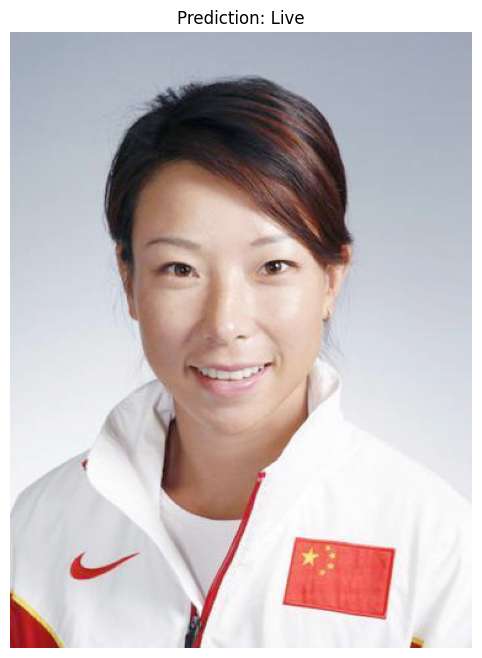

Predicted class: 1, Probabilities: [[0.347079   0.65292096]]


In [90]:
# Example usage
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10152/live/560993.png'
predicted_class, probs = crop_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

In [ ]:
# Example usage
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10001/spoof/509912.png'
predicted_class, probs = crop_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

In [ ]:
# Example usage
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5336/live/560932.png'
predicted_class, probs = crop_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

In [ ]:
# Example usage
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10047/spoof/499389.png'
predicted_class, probs = crop_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

In [ ]:
# Example usage
image_path = '/kaggle/input/my-image/MyFace.jpg'
predicted_class, probs = crop_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

### Predict the Whole Image

In [ ]:
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageDraw
from torchvision import transforms

def full_predict(image_path, model, device, transform):
    model.eval()
    
    image = Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    
    # Load original image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    label = "Live" if predicted_class == 1 else "Spoof"
    
    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()
    
    return predicted_class, probs.cpu().numpy()

In [ ]:
# Example usage
image_path = '/kaggle/input/my-image/MyFace.jpg'
predicted_class, probs = full_predict(image_path, model, device, transforms['test'])
print(f"Predicted class: {predicted_class}, Probabilities: {probs}")

## Predict the Fourier Transform of the Image

In [ ]:
from torchvision import transforms as tf

# Function to perform Fourier Transform
def fourier_transform_image(image_path):
    image = Image.open(image_path).convert('L')
    image_np = np.array(image)
    f = np.fft.fft2(image_np)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = Image.fromarray(magnitude_spectrum).convert('L')
    return magnitude_spectrum

def generate_FT(image_path):
    image = Image.open(image_path)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fimg = np.log(np.abs(fshift)+1)
    maxx = -1
    minn = 100000
    for i in range(len(fimg)):
        if maxx < max(fimg[i]):
            maxx = max(fimg[i])
        if minn > min(fimg[i]):
            minn = min(fimg[i])
    fimg = (fimg - minn+1) / (maxx - minn+1)
    return fimg

# Function for prediction with Fourier Transform
def predict_fourier(image_path, model, device, transform):
    model.eval()
#     magnitude_spectrum = fourier_transform_image(image_path)
#     input_tensor = transform(magnitude_spectrum).unsqueeze(0).to(device)

    ft_sample = generate_FT(image_path)
    print(ft_sample.shape, type(ft_sample))
    ft_sample = cv2.resize(ft_sample, (224, 224))
    ft_sample = torch.from_numpy(ft_sample).float()
    ft_sample = torch.unsqueeze(ft_sample, 0)
    # Replicate the single channel to three channels (3, 224, 224)
    ft_sample = ft_sample.repeat(3, 1, 1)
#     input_tensor = transform(tf.ToPILImage(ft_sample)).unsqueeze(0).to(device)
    input_tensor = ft_sample.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
#         output = model(ft_sample)
        probs = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
    image = Image.open(image_path)
    label = "Live" if predicted_class == 1 else "Spoof"
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prediction with Fourier: {label}")
    plt.axis('off')
    plt.show()
    return predicted_class, probs.cpu().numpy()

In [ ]:
image_path = '/kaggle/input/my-image/MyFace.jpg'
ft_img = generate_FT(image_path)
ft_img = cv2.resize(ft_img, (224, 224))
ft_img = torch.from_numpy(ft_img).float()
ft_img = torch.unsqueeze(ft_img, 0)
# Replicate the single channel to three channels (3, 224, 224)
ft_img = ft_img.repeat(3, 1, 1)
# ft_img.shape
from torchvision import transforms as tf
tf.ToPILImage(ft_img)

In [ ]:
image_path = '/kaggle/input/my-image/MyFace.jpg'
predicted_class, probs = predict_fourier(image_path, model, device, transforms['test'])
print(f"Predicted class with Fourier: {predicted_class}, Probabilities: {probs}")

In [ ]:
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/10155/spoof/535302.png'
predicted_class, probs = predict_fourier(image_path, model, device, transforms['test'])
print(f"Predicted class with Fourier: {predicted_class}, Probabilities: {probs}")

In [ ]:
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5237/spoof/504671.png'
predicted_class, probs = predict_fourier(image_path, model, device, transforms['test'])
print(f"Predicted class with Fourier: {predicted_class}, Probabilities: {probs}")

In [ ]:
image_path = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5335/live/552669.png'
predicted_class, probs = predict_fourier(image_path, model, device, transforms['test'])
print(f"Predicted class with Fourier: {predicted_class}, Probabilities: {probs}")